## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [0]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

--2019-10-10 13:22:39--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.84.11
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.84.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip’

train-test-data.zip 100%[===================>] 322.93M  71.7MB/s    in 4.7s    

2019-10-10 13:22:44 (69.0 MB/s) - ‘/data/train-test-data.zip’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip
   creating: /data/test/
  inflating: /data/test/Abdel_Aziz_Al-Hakim_00.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_01.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_10.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_11.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_40.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_41.jpg  
  inflating: /data/test/Abdullah_Gul_10.j

<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [0]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
#from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [0]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=36864, out_features=3000, bias=True)
  (fc_drop1): Dropout(p=0.2, inplace=False)
  (fc_drop2): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=3000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
)


In [0]:
# run with GPU on google colab (cannot run on udacity workspace due to too slow)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

net.to(device)

cuda:0


Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=36864, out_features=3000, bias=True)
  (fc_drop1): Dropout(p=0.2, inplace=False)
  (fc_drop2): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=3000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
)

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [0]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [0]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [0]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [0]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [0]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [0]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor).to(device)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [0]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [0]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

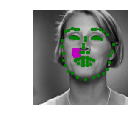

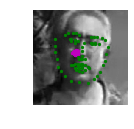

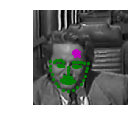

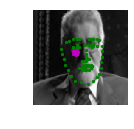

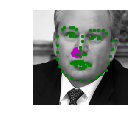

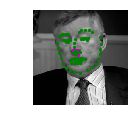

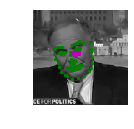

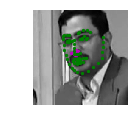

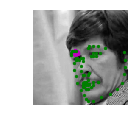

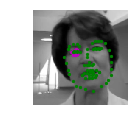

In [0]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images.cpu(), test_outputs.cpu(), gt_pts.cpu())

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [0]:
## TODO: Define the loss and optimization
import torch.optim as optim

#criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()

#optimizer = optim.SGD(net.parameters(), lr=0.0005, momentum=0.4)
optimizer = optim.Adam(net.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [0]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor).to(device)
            images = images.type(torch.FloatTensor).to(device)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [0]:
# train your network
n_epochs = 15 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
# with active_session():
train_net(n_epochs)

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.41231646537780764
Epoch: 1, Batch: 20, Avg. Loss: 0.14184130020439625
Epoch: 1, Batch: 30, Avg. Loss: 0.11169025525450707
Epoch: 1, Batch: 40, Avg. Loss: 0.11068956777453423
Epoch: 1, Batch: 50, Avg. Loss: 0.08756963685154914
Epoch: 1, Batch: 60, Avg. Loss: 0.09913889281451702
Epoch: 1, Batch: 70, Avg. Loss: 0.09575749523937702
Epoch: 1, Batch: 80, Avg. Loss: 0.08646610267460346
Epoch: 1, Batch: 90, Avg. Loss: 0.08406606763601303
Epoch: 1, Batch: 100, Avg. Loss: 0.09513514898717404
Epoch: 1, Batch: 110, Avg. Loss: 0.10549798235297203
Epoch: 1, Batch: 120, Avg. Loss: 0.0762162994593382
Epoch: 1, Batch: 130, Avg. Loss: 0.09351324178278446
Epoch: 1, Batch: 140, Avg. Loss: 0.09555328823626041
Epoch: 1, Batch: 150, Avg. Loss: 0.10677150785923004
Epoch: 1, Batch: 160, Avg. Loss: 0.09300718382000923
Epoch: 1, Batch: 170, Avg. Loss: 0.08725195080041885
Epoch: 1, Batch: 180, Avg. Loss: 0.10760764218866825
Epoch: 1, Batch: 190, Avg. Loss: 0.10318682976067066
Epo

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.08122187778353691
Epoch: 2, Batch: 20, Avg. Loss: 0.08820969350636006
Epoch: 2, Batch: 30, Avg. Loss: 0.08121866956353188
Epoch: 2, Batch: 40, Avg. Loss: 0.10370321720838546
Epoch: 2, Batch: 50, Avg. Loss: 0.08005120195448398
Epoch: 2, Batch: 60, Avg. Loss: 0.08490344136953354
Epoch: 2, Batch: 70, Avg. Loss: 0.0783197907730937
Epoch: 2, Batch: 80, Avg. Loss: 0.10543699711561202
Epoch: 2, Batch: 90, Avg. Loss: 0.07646509930491448
Epoch: 2, Batch: 100, Avg. Loss: 0.08718845434486866
Epoch: 2, Batch: 110, Avg. Loss: 0.08863430842757225
Epoch: 2, Batch: 120, Avg. Loss: 0.07500270232558251
Epoch: 2, Batch: 130, Avg. Loss: 0.06532191894948483
Epoch: 2, Batch: 140, Avg. Loss: 0.07210852764546871
Epoch: 2, Batch: 150, Avg. Loss: 0.07040511891245842
Epoch: 2, Batch: 160, Avg. Loss: 0.08349327556788921
Epoch: 2, Batch: 170, Avg. Loss: 0.07381187975406647
Epoch: 2, Batch: 180, Avg. Loss: 0.07793030627071858
Epoch: 2, Batch: 190, Avg. Loss: 0.09280335791409015
Epo

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.07196339704096318
Epoch: 3, Batch: 20, Avg. Loss: 0.06815054789185523
Epoch: 3, Batch: 30, Avg. Loss: 0.06828388459980488
Epoch: 3, Batch: 40, Avg. Loss: 0.07306885048747062
Epoch: 3, Batch: 50, Avg. Loss: 0.07222749553620815
Epoch: 3, Batch: 60, Avg. Loss: 0.10113622285425664
Epoch: 3, Batch: 70, Avg. Loss: 0.09166110903024674
Epoch: 3, Batch: 80, Avg. Loss: 0.060564416088163854
Epoch: 3, Batch: 90, Avg. Loss: 0.06970657482743263
Epoch: 3, Batch: 100, Avg. Loss: 0.08046302571892738
Epoch: 3, Batch: 110, Avg. Loss: 0.07612885981798172
Epoch: 3, Batch: 120, Avg. Loss: 0.06548908948898316
Epoch: 3, Batch: 130, Avg. Loss: 0.07238761037588119
Epoch: 3, Batch: 140, Avg. Loss: 0.06563145741820335
Epoch: 3, Batch: 150, Avg. Loss: 0.0824913963675499
Epoch: 3, Batch: 160, Avg. Loss: 0.07948998138308525
Epoch: 3, Batch: 170, Avg. Loss: 0.08978107832372188
Epoch: 3, Batch: 180, Avg. Loss: 0.07145146392285824
Epoch: 3, Batch: 190, Avg. Loss: 0.07532621622085571
Ep

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.06572337709367275
Epoch: 4, Batch: 20, Avg. Loss: 0.06586820296943188
Epoch: 4, Batch: 30, Avg. Loss: 0.08178832940757275
Epoch: 4, Batch: 40, Avg. Loss: 0.06759575009346008
Epoch: 4, Batch: 50, Avg. Loss: 0.057158955745399
Epoch: 4, Batch: 60, Avg. Loss: 0.055717994645237925
Epoch: 4, Batch: 70, Avg. Loss: 0.0613238800317049
Epoch: 4, Batch: 80, Avg. Loss: 0.07635002359747886
Epoch: 4, Batch: 90, Avg. Loss: 0.0890483245253563
Epoch: 4, Batch: 100, Avg. Loss: 0.05690328869968653
Epoch: 4, Batch: 110, Avg. Loss: 0.06064200159162283
Epoch: 4, Batch: 120, Avg. Loss: 0.05569418203085661
Epoch: 4, Batch: 130, Avg. Loss: 0.05675347484648228
Epoch: 4, Batch: 140, Avg. Loss: 0.08143206872045994
Epoch: 4, Batch: 150, Avg. Loss: 0.07830902673304081
Epoch: 4, Batch: 160, Avg. Loss: 0.07453211806714535
Epoch: 4, Batch: 170, Avg. Loss: 0.0715882085263729
Epoch: 4, Batch: 180, Avg. Loss: 0.058230404555797574
Epoch: 4, Batch: 190, Avg. Loss: 0.07319901548326016
Epoch

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.05121515188366175
Epoch: 5, Batch: 20, Avg. Loss: 0.07025545779615641
Epoch: 5, Batch: 30, Avg. Loss: 0.054743087664246556
Epoch: 5, Batch: 40, Avg. Loss: 0.05793161541223526
Epoch: 5, Batch: 50, Avg. Loss: 0.05063895527273417
Epoch: 5, Batch: 60, Avg. Loss: 0.056390457600355146
Epoch: 5, Batch: 70, Avg. Loss: 0.05855923313647508
Epoch: 5, Batch: 80, Avg. Loss: 0.06135059539228678
Epoch: 5, Batch: 90, Avg. Loss: 0.053673576936125754
Epoch: 5, Batch: 100, Avg. Loss: 0.05732560455799103
Epoch: 5, Batch: 110, Avg. Loss: 0.05208663027733564
Epoch: 5, Batch: 120, Avg. Loss: 0.05082222707569599
Epoch: 5, Batch: 130, Avg. Loss: 0.08295558504760266
Epoch: 5, Batch: 140, Avg. Loss: 0.06688449289649726
Epoch: 5, Batch: 150, Avg. Loss: 0.058139833994209765
Epoch: 5, Batch: 160, Avg. Loss: 0.06025269217789173
Epoch: 5, Batch: 170, Avg. Loss: 0.06481530033051967
Epoch: 5, Batch: 180, Avg. Loss: 0.049307831935584544
Epoch: 5, Batch: 190, Avg. Loss: 0.065093618631362

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.05829446502029896
Epoch: 6, Batch: 20, Avg. Loss: 0.05841031037271023
Epoch: 6, Batch: 30, Avg. Loss: 0.04390324261039495
Epoch: 6, Batch: 40, Avg. Loss: 0.04669809229671955
Epoch: 6, Batch: 50, Avg. Loss: 0.05272516701370478
Epoch: 6, Batch: 60, Avg. Loss: 0.05550089217722416
Epoch: 6, Batch: 70, Avg. Loss: 0.0613881791010499
Epoch: 6, Batch: 80, Avg. Loss: 0.055319683998823165
Epoch: 6, Batch: 90, Avg. Loss: 0.051763991639018056
Epoch: 6, Batch: 100, Avg. Loss: 0.04839225746691227
Epoch: 6, Batch: 110, Avg. Loss: 0.0461952468380332
Epoch: 6, Batch: 120, Avg. Loss: 0.03920865170657635
Epoch: 6, Batch: 130, Avg. Loss: 0.04677933547645807
Epoch: 6, Batch: 140, Avg. Loss: 0.05767736192792654
Epoch: 6, Batch: 150, Avg. Loss: 0.03952215611934662
Epoch: 6, Batch: 160, Avg. Loss: 0.06019390020519495
Epoch: 6, Batch: 170, Avg. Loss: 0.0436931274831295
Epoch: 6, Batch: 180, Avg. Loss: 0.05110180377960205
Epoch: 6, Batch: 190, Avg. Loss: 0.05161756575107575
Epo

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.04022457730025053
Epoch: 7, Batch: 20, Avg. Loss: 0.05277702659368515
Epoch: 7, Batch: 30, Avg. Loss: 0.041273527406156064
Epoch: 7, Batch: 40, Avg. Loss: 0.060644232854247096
Epoch: 7, Batch: 50, Avg. Loss: 0.043968575447797774
Epoch: 7, Batch: 60, Avg. Loss: 0.05313291810452938
Epoch: 7, Batch: 70, Avg. Loss: 0.041076289303600785
Epoch: 7, Batch: 80, Avg. Loss: 0.05675159525126219
Epoch: 7, Batch: 90, Avg. Loss: 0.044907722249627115
Epoch: 7, Batch: 100, Avg. Loss: 0.06774260606616736
Epoch: 7, Batch: 110, Avg. Loss: 0.05690105333924293
Epoch: 7, Batch: 120, Avg. Loss: 0.03640669453889132
Epoch: 7, Batch: 130, Avg. Loss: 0.0680088685825467
Epoch: 7, Batch: 140, Avg. Loss: 0.041032263170927764
Epoch: 7, Batch: 150, Avg. Loss: 0.04660067409276962
Epoch: 7, Batch: 160, Avg. Loss: 0.05941623356193304
Epoch: 7, Batch: 170, Avg. Loss: 0.046379274874925616
Epoch: 7, Batch: 180, Avg. Loss: 0.04908069297671318
Epoch: 7, Batch: 190, Avg. Loss: 0.04460184052586

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.04600706547498703
Epoch: 8, Batch: 20, Avg. Loss: 0.03856557048857212
Epoch: 8, Batch: 30, Avg. Loss: 0.04572616275399923
Epoch: 8, Batch: 40, Avg. Loss: 0.04306776616722345
Epoch: 8, Batch: 50, Avg. Loss: 0.042914087697863576
Epoch: 8, Batch: 60, Avg. Loss: 0.05685763768851757
Epoch: 8, Batch: 70, Avg. Loss: 0.04737873785197735
Epoch: 8, Batch: 80, Avg. Loss: 0.04417704846709967
Epoch: 8, Batch: 90, Avg. Loss: 0.04778235517442227
Epoch: 8, Batch: 100, Avg. Loss: 0.061619149148464204
Epoch: 8, Batch: 110, Avg. Loss: 0.05001013278961182
Epoch: 8, Batch: 120, Avg. Loss: 0.043040452897548674
Epoch: 8, Batch: 130, Avg. Loss: 0.04211725704371929
Epoch: 8, Batch: 140, Avg. Loss: 0.05639730244874954
Epoch: 8, Batch: 150, Avg. Loss: 0.04443418513983488
Epoch: 8, Batch: 160, Avg. Loss: 0.059549052454531196
Epoch: 8, Batch: 170, Avg. Loss: 0.03212484885007143
Epoch: 8, Batch: 180, Avg. Loss: 0.0337216155603528
Epoch: 8, Batch: 190, Avg. Loss: 0.04586598929017782

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.03149992302060127
Epoch: 9, Batch: 20, Avg. Loss: 0.03369282931089401
Epoch: 9, Batch: 30, Avg. Loss: 0.033430544659495354
Epoch: 9, Batch: 40, Avg. Loss: 0.03763687964528799
Epoch: 9, Batch: 50, Avg. Loss: 0.031730121746659276
Epoch: 9, Batch: 60, Avg. Loss: 0.037150385696440934
Epoch: 9, Batch: 70, Avg. Loss: 0.038913206197321415
Epoch: 9, Batch: 80, Avg. Loss: 0.03503032606095076
Epoch: 9, Batch: 90, Avg. Loss: 0.05289299096912146
Epoch: 9, Batch: 100, Avg. Loss: 0.04151955433189869
Epoch: 9, Batch: 110, Avg. Loss: 0.03374911081045866
Epoch: 9, Batch: 120, Avg. Loss: 0.05634886790066958
Epoch: 9, Batch: 130, Avg. Loss: 0.03117985650897026
Epoch: 9, Batch: 140, Avg. Loss: 0.030857534147799015
Epoch: 9, Batch: 150, Avg. Loss: 0.029805521480739117
Epoch: 9, Batch: 160, Avg. Loss: 0.0458133228123188
Epoch: 9, Batch: 170, Avg. Loss: 0.04316841661930084
Epoch: 9, Batch: 180, Avg. Loss: 0.05124713964760304
Epoch: 9, Batch: 190, Avg. Loss: 0.034932772442698

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.04182367119938135
Epoch: 10, Batch: 20, Avg. Loss: 0.04088575951755047
Epoch: 10, Batch: 30, Avg. Loss: 0.03673099800944328
Epoch: 10, Batch: 40, Avg. Loss: 0.03846247978508473
Epoch: 10, Batch: 50, Avg. Loss: 0.03336335252970457
Epoch: 10, Batch: 60, Avg. Loss: 0.04812466390430927
Epoch: 10, Batch: 70, Avg. Loss: 0.04669513069093227
Epoch: 10, Batch: 80, Avg. Loss: 0.03985922802239657
Epoch: 10, Batch: 90, Avg. Loss: 0.049201885052025315
Epoch: 10, Batch: 100, Avg. Loss: 0.03749080542474985
Epoch: 10, Batch: 110, Avg. Loss: 0.03643017839640379
Epoch: 10, Batch: 120, Avg. Loss: 0.027130134962499143
Epoch: 10, Batch: 130, Avg. Loss: 0.055529454723000526
Epoch: 10, Batch: 140, Avg. Loss: 0.03453519716858864
Epoch: 10, Batch: 150, Avg. Loss: 0.03145422441884875
Epoch: 10, Batch: 160, Avg. Loss: 0.02595861367881298
Epoch: 10, Batch: 170, Avg. Loss: 0.030396056175231934
Epoch: 10, Batch: 180, Avg. Loss: 0.036125847697258
Epoch: 10, Batch: 190, Avg. Loss: 0

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.031880592554807664
Epoch: 11, Batch: 20, Avg. Loss: 0.028899135999381542
Epoch: 11, Batch: 30, Avg. Loss: 0.04074952527880669
Epoch: 11, Batch: 40, Avg. Loss: 0.03501168545335531
Epoch: 11, Batch: 50, Avg. Loss: 0.050140407867729664
Epoch: 11, Batch: 60, Avg. Loss: 0.03703291155397892
Epoch: 11, Batch: 70, Avg. Loss: 0.02934826575219631
Epoch: 11, Batch: 80, Avg. Loss: 0.029427820071578025
Epoch: 11, Batch: 90, Avg. Loss: 0.02369610024616122
Epoch: 11, Batch: 100, Avg. Loss: 0.036836706846952436
Epoch: 11, Batch: 110, Avg. Loss: 0.033619411289691925
Epoch: 11, Batch: 120, Avg. Loss: 0.02374487165361643
Epoch: 11, Batch: 130, Avg. Loss: 0.031445142533630135
Epoch: 11, Batch: 140, Avg. Loss: 0.05008911965414882
Epoch: 11, Batch: 150, Avg. Loss: 0.029264897853136063
Epoch: 11, Batch: 160, Avg. Loss: 0.028401346411556005
Epoch: 11, Batch: 170, Avg. Loss: 0.04011657256633043
Epoch: 11, Batch: 180, Avg. Loss: 0.027036620117723942
Epoch: 11, Batch: 190, Avg.

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.024863239750266074
Epoch: 12, Batch: 20, Avg. Loss: 0.03415664546191692
Epoch: 12, Batch: 30, Avg. Loss: 0.024786767922341822
Epoch: 12, Batch: 40, Avg. Loss: 0.02822748338803649
Epoch: 12, Batch: 50, Avg. Loss: 0.02285436764359474
Epoch: 12, Batch: 60, Avg. Loss: 0.03154770331457257
Epoch: 12, Batch: 70, Avg. Loss: 0.037788587622344494
Epoch: 12, Batch: 80, Avg. Loss: 0.026621286012232303
Epoch: 12, Batch: 90, Avg. Loss: 0.03300856444984675
Epoch: 12, Batch: 100, Avg. Loss: 0.037361235544085505
Epoch: 12, Batch: 110, Avg. Loss: 0.026774021051824092
Epoch: 12, Batch: 120, Avg. Loss: 0.022730195708572865
Epoch: 12, Batch: 130, Avg. Loss: 0.0361837811768055
Epoch: 12, Batch: 140, Avg. Loss: 0.03290233034640551
Epoch: 12, Batch: 150, Avg. Loss: 0.034563615918159485
Epoch: 12, Batch: 160, Avg. Loss: 0.027689322549849748
Epoch: 12, Batch: 170, Avg. Loss: 0.03454122096300125
Epoch: 12, Batch: 180, Avg. Loss: 0.04483891129493713
Epoch: 12, Batch: 190, Avg. L

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.030766036175191403
Epoch: 13, Batch: 20, Avg. Loss: 0.029310453683137894
Epoch: 13, Batch: 30, Avg. Loss: 0.040752247069031
Epoch: 13, Batch: 40, Avg. Loss: 0.03839236656203866
Epoch: 13, Batch: 50, Avg. Loss: 0.03142978698015213
Epoch: 13, Batch: 60, Avg. Loss: 0.039259671419858935
Epoch: 13, Batch: 70, Avg. Loss: 0.0394442549906671
Epoch: 13, Batch: 80, Avg. Loss: 0.033885385282337664
Epoch: 13, Batch: 90, Avg. Loss: 0.030764341168105603
Epoch: 13, Batch: 100, Avg. Loss: 0.03965468518435955
Epoch: 13, Batch: 110, Avg. Loss: 0.027443850133568048
Epoch: 13, Batch: 120, Avg. Loss: 0.032805587723851205
Epoch: 13, Batch: 130, Avg. Loss: 0.03615734428167343
Epoch: 13, Batch: 140, Avg. Loss: 0.03252186551690102
Epoch: 13, Batch: 150, Avg. Loss: 0.025640529673546554
Epoch: 13, Batch: 160, Avg. Loss: 0.025214791484177112
Epoch: 13, Batch: 170, Avg. Loss: 0.03127141995355487
Epoch: 13, Batch: 180, Avg. Loss: 0.03609979562461376
Epoch: 13, Batch: 190, Avg. Los

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.024738800525665284
Epoch: 14, Batch: 20, Avg. Loss: 0.029255989752709866
Epoch: 14, Batch: 30, Avg. Loss: 0.023967021983116864
Epoch: 14, Batch: 40, Avg. Loss: 0.028494374454021455
Epoch: 14, Batch: 50, Avg. Loss: 0.02481796285137534
Epoch: 14, Batch: 60, Avg. Loss: 0.04767923792824149
Epoch: 14, Batch: 70, Avg. Loss: 0.02639791592955589
Epoch: 14, Batch: 80, Avg. Loss: 0.032172553800046445
Epoch: 14, Batch: 90, Avg. Loss: 0.02566223293542862
Epoch: 14, Batch: 100, Avg. Loss: 0.03485933504998684
Epoch: 14, Batch: 110, Avg. Loss: 0.038845778070390226
Epoch: 14, Batch: 120, Avg. Loss: 0.06744518829509616
Epoch: 14, Batch: 130, Avg. Loss: 0.04351585581898689
Epoch: 14, Batch: 140, Avg. Loss: 0.028262722492218017
Epoch: 14, Batch: 150, Avg. Loss: 0.042624992318451405
Epoch: 14, Batch: 160, Avg. Loss: 0.022648310847580434
Epoch: 14, Batch: 170, Avg. Loss: 0.04027301948517561
Epoch: 14, Batch: 180, Avg. Loss: 0.03126977700740099
Epoch: 14, Batch: 190, Avg. 

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.029382474534213544
Epoch: 15, Batch: 20, Avg. Loss: 0.02727019926533103
Epoch: 15, Batch: 30, Avg. Loss: 0.028117056097835304
Epoch: 15, Batch: 40, Avg. Loss: 0.03681430350989103
Epoch: 15, Batch: 50, Avg. Loss: 0.023005434684455393
Epoch: 15, Batch: 60, Avg. Loss: 0.02320284815505147
Epoch: 15, Batch: 70, Avg. Loss: 0.028198380768299103
Epoch: 15, Batch: 80, Avg. Loss: 0.025280644558370112
Epoch: 15, Batch: 90, Avg. Loss: 0.0296040840446949
Epoch: 15, Batch: 100, Avg. Loss: 0.043832121416926384
Epoch: 15, Batch: 110, Avg. Loss: 0.024794976972043515
Epoch: 15, Batch: 120, Avg. Loss: 0.025650384556502103
Epoch: 15, Batch: 130, Avg. Loss: 0.05823507644236088
Epoch: 15, Batch: 140, Avg. Loss: 0.04930933676660061
Epoch: 15, Batch: 150, Avg. Loss: 0.02718867640942335
Epoch: 15, Batch: 160, Avg. Loss: 0.02655414855107665
Epoch: 15, Batch: 170, Avg. Loss: 0.03416060637682676
Epoch: 15, Batch: 180, Avg. Loss: 0.029004664439707995
Epoch: 15, Batch: 190, Avg. L

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [0]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


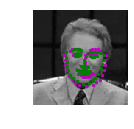

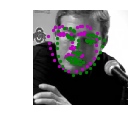

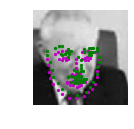

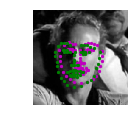

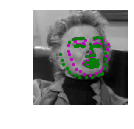

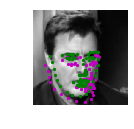

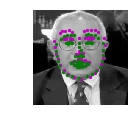

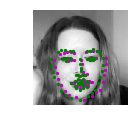

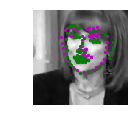

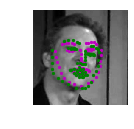

In [0]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images.cpu(), test_outputs.cpu(), gt_pts.cpu())


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [0]:
## TODO: change the name to something uniqe for each new model
model_dir = 'sample_data/'
model_name = 'keypoints_model_with_SmoothL1Loss_and_Adam.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: I use SmoothL1Loss for the loss function because I see that when using this, the Loss value is reduce. It's better than MSELoss. For optimization: I've tried beetween SGD and Adam, and Adam produce better performance, so I've choose Adam

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: The first time I start with 2 conv layers, 2 max pooling layers, 1 dropout layer and 2 linear layers. After tried with some architectures, I've add 2 more conv layers + 1 linear layer to get better performance. Beetween those layers, I've added dropout layer to avoid overfitting

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: The bigger batch_size, the fewer update on the Loss. So the batch_size need to me small or medium to have better performance. I choose batch_size = 10 because it give the best performance to compare with the other values.

For epochs: the Loss value will not decrease much after 15 epochs, so I choose 15 as a number of epochs

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.00896232 -0.00395527 -0.00040355  0.00237012  0.00595272]
 [ 0.00346282  0.00644569  0.00856093  0.01051229  0.01333631]
 [ 0.01229338  0.01374265  0.0153338   0.01681724  0.01984227]
 [ 0.01397047  0.01674535  0.01797999  0.01940489  0.02095578]
 [ 0.00294189  0.00861511  0.0112954   0.01212922  0.01140313]]
(5, 5)


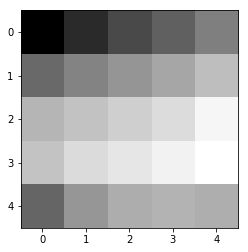

In [75]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.cpu().numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

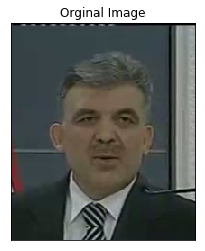

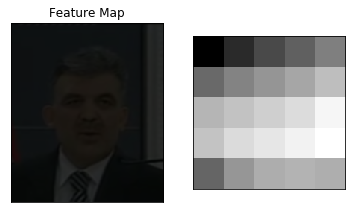

In [79]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
import cv2
image = cv2.imread('Abdullah_Gul_30.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.xticks([]), plt.yticks([])
plt.title("Orginal Image")

# Applying
filtered = cv2.filter2D(image, -1, w[filter_index][0])

# Visualization
fig = plt.figure()
ax = fig.add_subplot(121, xticks = [], yticks = [])
ax.imshow(filtered)
ax.set_title("Feature Map")
ax = fig.add_subplot(122, xticks = [], yticks = [])
ax.imshow(w[filter_index][0], cmap = 'gray')

plt.show()


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: the purpose of this layer is to blurred out and reduce noise

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!